1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

time of decay in seconds 55


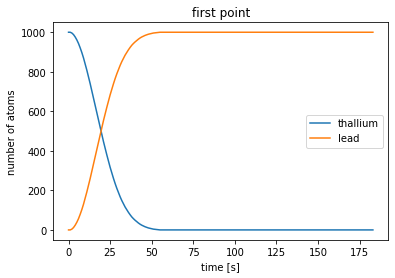

time of decay in seconds 646


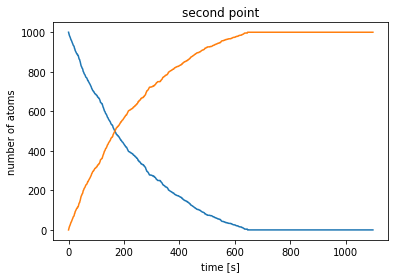

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
def decay(r, atoms_thallium, p):
    temp = np.array([atoms_thallium])
    for i in range(r - 1):
        temp = np.append(temp, int(temp[i] - p[i]*temp[i]) )
    return temp


# 1
tau = int(np.ceil(3.052*60)) # secs
atoms_thallium = 1000
atoms_lead = 0

step = 1 # secs

# decay probability
def p(t, tau):
    return 1 - 2**(-t/tau)
    
t = np.arange(tau)

temp_thallium = decay(tau, atoms_thallium, p(t, tau))

temp_lead = atoms_thallium - temp_thallium

decay_time = t[temp_thallium == 0][0]

print('time of decay in seconds', decay_time)

plt.title('first point')
plt.xlabel("time [s]")
plt.ylabel("number of atoms")
plt.plot(t, temp_thallium)
plt.plot(t, temp_lead)
plt.legend(["thallium", "lead"])
plt.show()

# 2

def p1(t, tau):
    return 2**(-t/tau)*(np.log(2))/tau

def cdf1(t, tau):
    return 1 - 2**(-t/tau)

def inverse_cdf1(z, tau):
    return -tau*np.log2(1-z)

def decay_2(i_cdf):
    temp_lead = []
    for i in range(1,len(i_cdf)):
        temp_lead.append(sum(1 if (x>=i-1 and x < i) else 0 for x in i_cdf))
    temp_lead = np.cumsum(temp_lead)
    temp_lead[temp_lead > 1000] = 1000
    return temp_lead

# each atom should have a decay time set
z = np.random.random(atoms_thallium + 100)
i_cdf = np.sort(inverse_cdf1(z,tau))

temp_lead = decay_2(i_cdf)
temp_thallium = np.repeat(atoms_thallium, temp_lead.size) - temp_lead

decay_time = np.arange(temp_lead.size)[temp_thallium == 0][0]
print('time of decay in seconds', decay_time)

plt.title('second point')
plt.xlabel("time [s]")
plt.ylabel("number of atoms")
plt.plot(temp_thallium)
plt.plot(temp_lead)
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

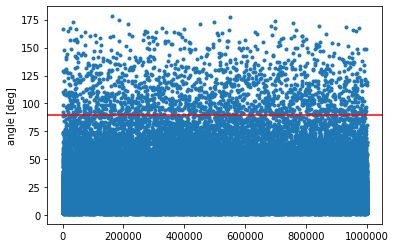

number of particles that bounce back 1602
fraction of particles that bounce back 0.001602


In [2]:
# simulate 2d distribution
def tetha(Z, E, b, electron):
    eps0 = 8.85*1e-12 # F/m
    return 2*np.arctan(Z*electron**2 / (2*np.pi*eps0*E*b))

Z = 79
electron = 1.60217*(10**-19)
E = 7.7*1e6*electron # ev -> V
# b is a 2D gaussian distr, with a0/100
a0 = 5.29177*(10**-11) #pm -> m bohr radius
sigma = a0/100

# cov = [[sigma, 0], [0, sigma]]
# mean = [0, 0]
# x, y = np.random.multivariate_normal(mean, cov, 10**6).T
x = np.random.rand(10**6)

# bounce back particles
b = np.sqrt(-2*(sigma)**(2)*np.log(1-x)) # beam impact param
angle = tetha(Z, E, b, electron)

plt.plot(np.rad2deg(angle), '.') # in degrees
plt.axhline(y=90, color='r', linestyle='-')
plt.ylabel('angle [deg]')
plt.show()

print('number of particles that bounce back', angle[angle > np.pi/2].size)
print('fraction of particles that bounce back', angle[angle > np.pi/2].size/angle.size)

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

C:\Users\hanah\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\hanah\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sin
  """


Monte Carlo hit/miss method 1.4492  error 0.2754 error2 0.0021999999999999797
Monte Carlo hit/miss method 1.4538950616300794 error 0.2730524691849604 error2 0.002495061630079398
error2 wrt value from wolframalpha 1.4514


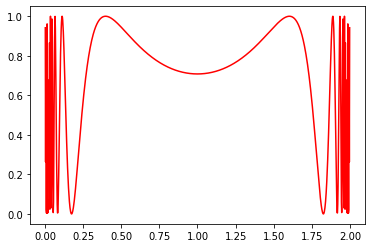

In [3]:
# 1D CASE
np.random.seed(1234)

def f(x):
    return np.sin(1/(x*(2-x)))**2

a = 0
b = 2
x=np.linspace(a,b,1000)
plt.plot(x,f(x),'r-')

# 1 hit/miss method - Monte Carlo integration
N = 100000
count = 0
for i in range(N):
    x = b*np.random.random()
    y = np.random.random()
    if y < f(x): # if the random sample is above count it, otherwise don't
        count += 1
# count = Area A = box area    
I = (b - a)/N*count
print('Monte Carlo hit/miss method',I, ' error', 1-count/N, 'error2', np.abs(I-1.4514))

# 2 mean value method - Monte Carlo integration
count = 0
for i in range(N):
    # uniformly draw random samples from the domain
    x = b*np.random.random()
    count += f(x)
I = (b - a)/N*count
print('Monte Carlo hit/miss method',I, 'error', 1-count/N, 'error2', np.abs(I-1.4514))
print('error2 wrt value from wolframalpha', 1.4514)

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [4]:
# 2D CASE
def f(x, y):
    if x**2+y**2 <= 1:
        return 1
    else:
        return 0
    
# 1 - result is np.pi
# mean value method - Monte Carlo integration
N = 10000
count = 0

for i in range(N):
    # uniformly draw random samples from the domain
    x = np.random.uniform(-1,1)
    y = np.random.uniform(-1,1)
    count += f(x,y)
    
I = 2*2/N*count
print('Monte Carlo estimate', I)
print('true area', np.pi*1**2)

# ND CASE
# 2 - generalization is np.pi
def f(x):
    if np.sum(x**2) <= 1:
        return 1
    else:
        return 0

dim = 10
count = 0
for i in range(N):
    x = np.random.uniform(-1,1,size=dim)
    count += f(x)

I = 2**dim/N*count
print('Monte Carlo estimate', I)

Monte Carlo estimate 3.1416
true area 3.141592653589793
Monte Carlo estimate 2.8672


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

C:\Users\hanah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


integral with importance sampling 0.7597806552889722


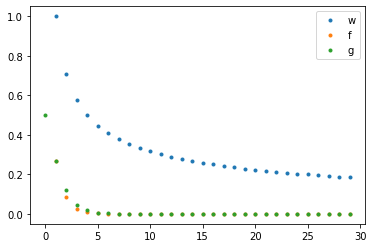

In [5]:
def w(x):
    return x**(-1/2)
    
def integralW(x):
    return 2*x**(1/2)

def f(x):
    return w(x)/(np.e**x+1)

def g(x):
    return 1/(np.e**x+1)

plt.plot(np.arange(0,30),w(np.arange(0,30)), '.')
plt.plot(np.arange(0,30),f(np.arange(0,30)), '.')
plt.plot(np.arange(0,30),g(np.arange(0,30)), '.')
plt.legend(['w','f','g'])

#constants
a = 0
b = 1
N = 10**6
x = np.random.rand(N)

I = 1/N*np.sum(f(x)/w(x))*(integralW(b)-integralW(a))
print('integral with importance sampling', I)